## 데이터셋 준비2

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!pip install pytimekr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytimekr import pytimekr
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns
from matplotlib import font_manager, rc
from tensorflow import keras

In [ ]:
# 파일 불러오기
df = pd.read_csv('/gdrive/MyDrive/DScover/미니프로젝트/data/combined_data_with_imputation.csv', index_col= 0)
df.head()

,날짜,시간,D-H,기온,강수량,풍속,습도,기압,전운량,시정,SO2,CO,O3,NO2,PM10,PM25,count
0,2020-01-01,0,2020-01-01-0,-6.5,0.0,0.0,38.0,1022.6,9.0,2000.0,0.004,1.0,0.002,0.047,45.0,33.0,50.0
1,2020-01-01,1,2020-01-01-1,-5.9,0.0,1.7,40.0,1021.8,9.0,2000.0,0.004,0.7,0.002,0.044,25.0,18.0,17.0
2,2020-01-01,2,2020-01-01-2,-5.7,0.0,0.1,42.0,1021.6,9.0,1988.0,0.004,0.7,0.002,0.043,26.0,18.0,30.0
3,2020-01-01,3,2020-01-01-3,-5.6,0.0,0.0,46.0,1021.5,9.0,2000.0,0.004,0.8,0.001,0.043,29.0,20.0,12.0
4,2020-01-01,4,2020-01-01-4,-5.4,0.0,0.0,50.0,1021.6,8.0,1908.0,0.003,0.6,0.002,0.040,26.0,18.0,14.0


In [ ]:
df['D-H'] = pd.to_datetime(df['D-H'],format='%Y-%m-%d-%H')
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.rename(columns = {'\b기압':'기압'})
df = df.set_index('D-H')

In [ ]:
# 휴일 피처 만들기
hol_2020 = pytimekr.holidays(year=2020)
hol_2021 = pytimekr.holidays(year=2021)
hol_2022 = pytimekr.holidays(year=2022)
holidays = hol_2020 + hol_2021 + hol_2022
holidayss = []
for i in holidays:
    tr = i.strftime('%Y-%m-%d')
    holidayss.append(tr)

In [ ]:
# Feature Engineering

def create_features(df):
    df['연도']= df.index.year
    df['분기'] = df.index.quarter
    df['달'] = df.index.month
    df['요일'] = df.index.weekday
    df['주말'] = df['요일'].apply(lambda x: "weekend" if x==5 or x==6 else "weekday")
    df['휴일'] = df['날짜'].apply(lambda x:"Holidays" if x in holidayss else "No Holidays")
    return df

df = create_features(df)

In [ ]:
# 필요없는 Feature 삭제
deletelist = ["날짜","CO","PM25"]
for i in deletelist:
    df = df.drop(i, axis=1)

In [ ]:
from collections import Counter 

def outlier_detecting(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_line = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_line) | (df[col] > Q3 + outlier_line)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = outlier_detecting(df, 2, df.describe().columns)
Outliers_to_drop

[Timestamp('2020-06-30 02:00:00'),
 Timestamp('2020-06-30 03:00:00'),
 Timestamp('2020-07-23 17:00:00'),
 Timestamp('2020-07-23 18:00:00'),
 Timestamp('2020-09-03 07:00:00'),
 Timestamp('2020-09-03 08:00:00'),
 Timestamp('2020-09-03 09:00:00'),
 Timestamp('2020-09-07 11:00:00'),
 Timestamp('2020-09-07 12:00:00'),
 Timestamp('2021-08-31 16:00:00'),
 Timestamp('2021-05-13 17:00:00'),
 Timestamp('2021-05-13 18:00:00')]

In [ ]:
week_day = pd.get_dummies(df['주말'])
holiday = pd.get_dummies(df['휴일'])

df = pd.concat([df,holiday,week_day],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19704 entries, 2020-01-01 00:00:00 to 2022-03-31 23:00:00
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           19704 non-null  int64  
 1   기온           19704 non-null  float64
 2   강수량          19704 non-null  float64
 3   풍속           19704 non-null  float64
 4   습도           19704 non-null  float64
 5   기압           19704 non-null  float64
 6   전운량          19704 non-null  float64
 7   시정           19704 non-null  float64
 8   SO2          19704 non-null  float64
 9   O3           19704 non-null  float64
 10  NO2          19704 non-null  float64
 11  PM10         19704 non-null  float64
 12  count        19704 non-null  float64
 13  연도           19704 non-null  int64  
 14  분기           19704 non-null  int64  
 15  달            19704 non-null  int64  
 16  요일           19704 non-null  int64  
 17  주말           19704 non-null  object 
 18  휴일         

In [ ]:
df.drop(['휴일','주말', '연도', '분기', '달'], axis=1, inplace=True)

## LSTM

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -0.786647
Kurtosis: 0.191831


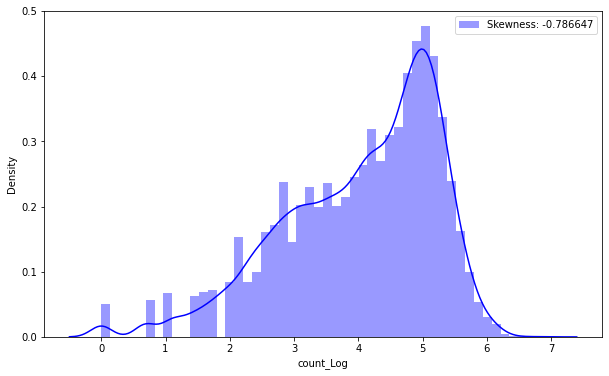

In [ ]:
df["count_Log"] = df["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df["count_Log"], color = "b", label="Skewness: {:2f}".format(df["count_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df['count_Log'].skew())
print("Kurtosis: %f" % df['count_Log'].kurt())

df.drop('count', axis= 1, inplace=True)

In [ ]:
# Train/Test Split
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

In [ ]:
# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning

columns_to_scale = ['기온', '강수량', '풍속', '습도', '기압', '전운량', '시정', 'SO2', 'O3', 'NO2', 'PM10']
scale_data = StandardScaler().fit(train[columns_to_scale].to_numpy())
cnt_data = StandardScaler().fit(train[['count_Log']])

train.loc[:,columns_to_scale] = scale_data.transform(train[columns_to_scale].to_numpy())
train['count_Log'] = cnt_data.transform(train[['count_Log']])

test.loc[:,columns_to_scale] = scale_data.transform(test[columns_to_scale].to_numpy())
test['count_Log'] = cnt_data.transform(test[['count_Log']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
def create_data_sequence(X, y, time_steps=1):
    input_sequence, output, times = [], [], []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)
        output.append(y.iloc[i + time_steps])
        times.append(X.index[i:(i+time_steps)])
    return np.array(input_sequence), np.array(output), np.array(times)

In [ ]:
time_steps = 24

training_set_sequence, training_set_output, train_times = create_data_sequence(train, train['count_Log'], time_steps)
test_set_sequence, test_set_output, test_times = create_data_sequence(test, test['count_Log'], time_steps)

print("Training data shape", training_set_sequence.shape, "Training data output shape", training_set_output.shape)
print("Test data shape", test_set_sequence.shape, "Test data output shape", test_set_output.shape)

Training data shape (16372, 24, 17) Training data output shape (16372,)
Test data shape (3260, 24, 17) Test data output shape (3260,)


In [ ]:
def machine_learning_model():
    
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=128,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    return model

In [ ]:
model = machine_learning_model()

history = model.fit(
    training_set_sequence,
    training_set_output, 
    epochs=10, 
    batch_size=64, 
    validation_split=0.2,
    shuffle=False,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74752     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
205/205 [==============================] - 28s 110ms/step - loss: 0.3453 - val_loss: 0.1775
Epoch 2/10
205/205 [==============================] - 11s 55ms/step - loss: 0.2071 - val_loss: 0.1445
Epoch 3/10
205/205 [==============================] - 11s 53ms/step - loss: 0.1667 - val_loss: 0.1320
Epoch 4/1

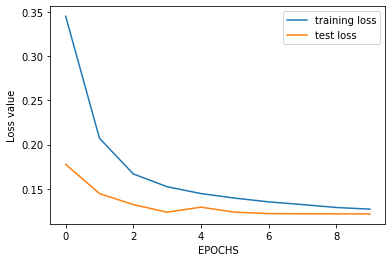

In [ ]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

In [ ]:
test_predictions = model.predict(test_set_sequence)

102/102 [==============================] - 3s 25ms/step


In [ ]:
model_predictions = cnt_data.inverse_transform(test_predictions)
actual_testset_values = cnt_data.inverse_transform(test_set_output.reshape(-1, 1))
df['count'] = np.exp(df['count_Log'])

In [ ]:
predict = pd.DataFrame({'prediction':np.exp(model_predictions.flatten()), 'actual':np.exp(actual_testset_values.flatten())})

predict = predict.set_index(test_times[:, 0])

In [ ]:
predict

,prediction,actual
2021-11-15 04:00:00,19.738581,12.0
2021-11-15 05:00:00,28.093967,29.0
2021-11-15 06:00:00,63.714050,77.0
2021-11-15 07:00:00,175.159103,158.0
2021-11-15 08:00:00,268.860962,314.0
...,...,...
2022-03-30 19:00:00,325.221924,253.0
2022-03-30 20:00:00,206.694138,168.0
2022-03-30 21:00:00,160.809235,151.0
2022-03-30 22:00:00,138.211395,133.0


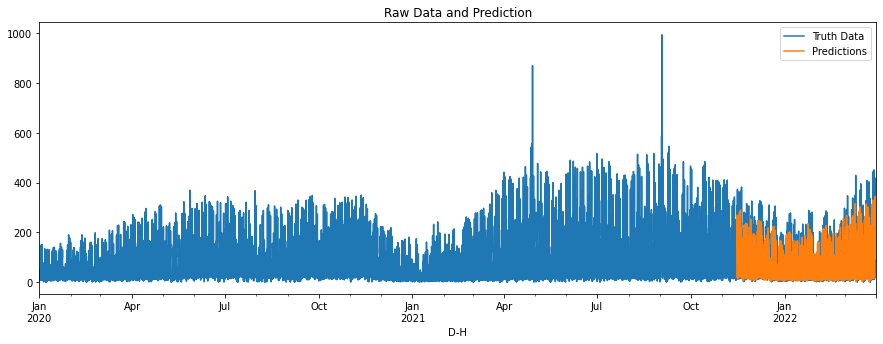

In [ ]:
ax = df[['count']].plot(figsize=(15,5))
predict['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

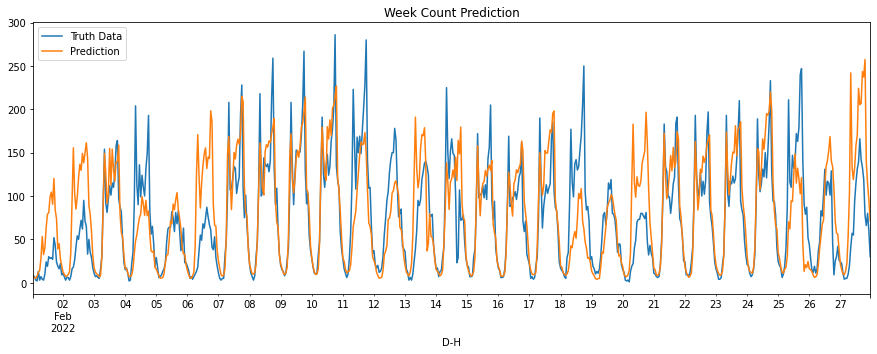

In [ ]:
ax = df.loc[(df.index > '2022-02-01') & (df.index < '2022-02-28')]['count'].plot(figsize=(15,5), title="Week Count Prediction")
predict.loc[(predict.index > '2022-02-01') & (predict.index < '2022-02-28')]['prediction'].plot()
plt.legend(['Truth Data', 'Prediction'])
plt.show()

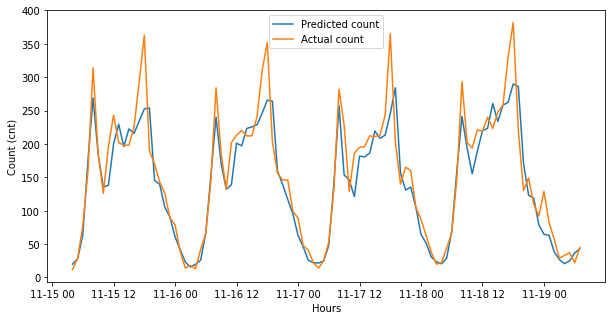

In [ ]:
fig,ax = plt.subplots(figsize = (10, 5))
plt.plot(predict['prediction'][:100,], label='Predicted count')
plt.plot(predict['actual'][:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred, p = 17):
  MAE = mean_absolute_error(y_test, y_pred)
  RMSE = mean_squared_error(y_test, y_pred)**0.5
  R2 = r2_score(y_test, y_pred)
  n = len(y_test)
  adjusted_R2 = 1-(1-R2)*(n-1)/(n-p-1)

  Result = pd.DataFrame(data = [MAE, RMSE, adjusted_R2],
                        index= ['MAE', 'RMSE', 'adjusted R2'],
                        columns = ['Result'])
  return Result

In [ ]:
confirm_result(actual_testset_values, model_predictions)

,Result
MAE,0.245509
RMSE,0.355674
adjusted R2,0.900772
